# Stochastic Runge-Kutta (SRK) demonstration
The `AbstractSRK` class takes a `StochasticButcherTableau` and implements the corresponding SRK method.
Depending on the tableau, the resulting method can either be used for general SDEs, or just for ones with additive noise.
The additive-noise-only methods are somewhat faster, but will fail if the noise is not additive.
Nevertheless, even in the additive noise case, the diffusion vector field can depend on time (just not on the state $y$). Then the SDE has the form:
$$
\mathrm{d}y = f(y, t) \mathrm{d}t + g(t) \mathrm{d}W_t.
$$
To account for time-dependent noise, the SRK adds a term to the output of each step, which allows it to still maintain its usual strong order of convergence.

The SRK is capable of utilising various types of time Levy area, depending on the tableau provided. It can use:
- just the Brownian motion $W$, withouth any Levy area
- $W$ and the space-time Levy area $H$
- $W$, $H$ and the space-time-time Levy area $K$.
For more information see the documentation of the `StochasticButcherTableau` class.

First we will demonstrate an additive-noise-only SRK method, the ShARK method, on an SDE with additive, time-dependent noise.
For more additive-noise SRKs see the langevin.ipynb notebook.

We will compare various additive-noise-only SRK methods as well as some general SRK methods proposed by Foster.

In [1]:
%env JAX_PLATFORM_NAME=cuda

from test.helpers import (
    get_mlp_sde,
    get_time_sde,
)

import diffrax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from diffrax import (
    diffeqsolve,
    GeneralShARK,
    ShARK,
    SlowRK,
    SPaRK,
    SRA1,
)
from drawing_and_evaluating import (
    constant_step_strong_order,
    draw_order_multiple,
    plot_sol_general,
)
from jax import config


config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=4, suppress=True)


# Plotting
def draw_order(results):
    steps, errs, order = results
    plt.plot(steps, errs)
    plt.yscale("log")
    plt.xscale("log")
    pretty_steps = [int(step) for step in steps]
    plt.xticks(ticks=pretty_steps, labels=pretty_steps)
    plt.ylabel("RMS error")
    plt.xlabel("average number of steps")
    plt.show()
    print(f"Order of convergence: {order:.4f}")


dtype = jnp.float64
key = jr.PRNGKey(2)
sde_key = jr.PRNGKey(11)
num_samples = 100
keys = jr.split(jr.PRNGKey(5678), num=num_samples)

t0, t1 = 0.0, 16.0
t_short = 4.0
t_long = 32.0
save_at_solver_steps = diffrax.SaveAt(steps=True)

time_sde = get_time_sde(t0, t1, dtype=dtype, noise_dim=7, key=sde_key)
terms_time_sde = time_sde.get_terms(
    time_sde.get_bm(key, levy_area="space-time", tol=2**-10)
)
time_sde_short = get_time_sde(t0, t_short, dtype=dtype, noise_dim=7, key=sde_key)

mlp_sde = get_mlp_sde(t0, t1, dtype=dtype, key=sde_key, noise_dim=3)
terms_mlp_sde = mlp_sde.get_terms(
    mlp_sde.get_bm(key, levy_area="space-time", tol=2**-10)
)
mlp_sde_short = get_mlp_sde(t0, t_short, dtype=dtype, key=sde_key, noise_dim=3)

commutative_sde = get_mlp_sde(t0, t1, dtype=dtype, key=sde_key, noise_dim=1)
terms_commutative_sde = commutative_sde.get_terms(
    commutative_sde.get_bm(key, levy_area="space-time", tol=2**-10)
)
commutative_sde_short = get_mlp_sde(t0, t_short, dtype=dtype, key=sde_key, noise_dim=1)

env: JAX_PLATFORM_NAME=cuda


## ShARK
`ShARK` is an SRK method for additive-noise SDEs. It uses two vector-field evaluations per step and has strong order 1.5, but applied to a Langevin SDE it has order 2.
 While it has the same order as `SRA1`, it has a better proportionality constant.

Based on equation (6.1) in
    Foster, J., dos Reis, G., & Strange, C. (2023).
    High order splitting methods for SDEs satisfying a commutativity condition.
    arXiv [Math.NA] http://arxiv.org/abs/2210.17543
    

## General ShARK
`GeneralShARK` is a generalisation of the ShARK method which now works for any SDE, not only those with additive noise. It uses three evaluations of the vector field per step and has the following strong orders of convergence:
- 2 for the Langevin SDEs
- 1.5 for additive noise SDEs
- 1 for commutative noise SDEs
- 0.5 for general SDEs.


## SRA1
Another method for additive-noise SDEs.
`SRA1` normally has strong order 1.5, but when applied to a Langevin SDE it has order 2. It natively supports adaptive-stepping via an embedded method for error estimation. Uses two evaluations of the vector-field per step.

Based on the SRA1 method from
    A. Rößler, Runge–Kutta methods for the strong approximation of solutions of stochastic differential equations,
    SIAM Journal on Numerical Analysis, 8 (2010), pp. 922–952.
    

## Shifted Additive-noise Euler (SEA)
This variant of the Euler-Maruyama makes use of the space-time Levy area, which improves its local error to $O(h^2)$ compared to $O(h^{1.5})$ of the standard Euler-Maruyama. Nevertheless, it has a strong order of only 1 for additive-noise SDEs.


 ## The "Space-Time Optimal Runge-Kutta" method
This is a general Stochastic Runge-Kutta method with 3 evaluations of the vector field per step,
based on Definition 1.6 from
Foster, J. (2023).
On the convergence of adaptive approximations for stochastic differential equations.
arXiv [Math.NA]. Retrieved from http://arxiv.org/abs/2311.14201

For general SDEs, this has order 0.5.
When the noise is commutative it has order 1.
When the noise is additive it has order 1.5.
For the Langevin SDE it has order 2.
Requires the space-time Levy area H.
It also natively supports adaptive time-stepping.


## SLOW-RK
This is a general Stochastic Runge-Kutta method with 7 stages (2 evaluations of the drift vector field and 5 evaluations of the diffusion vector field) per step. Remarkably, it has order 1.5 for commutative noise SDEs and order 0.5 for general SDEs.
Devised by James Foster.

# Comparison of the orders of convergence of various SRK methods
## General SDEs

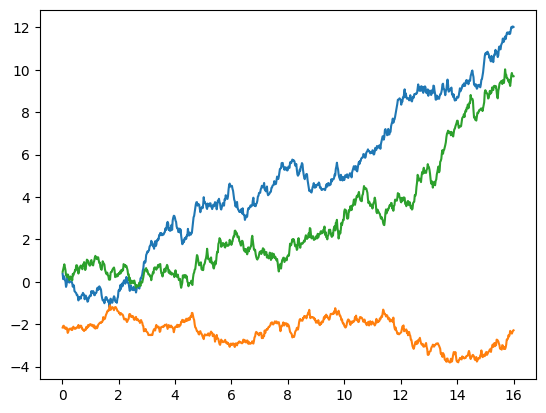

In [2]:
# A plot of the solution of the SDE used to compare the methods
sol_general = diffeqsolve(
    terms_mlp_sde,
    GeneralShARK(),
    t0,
    t1,
    dt0=0.02,
    y0=mlp_sde.y0,
    args=mlp_sde.args,
    saveat=diffrax.SaveAt(steps=True),
)
plot_sol_general(sol_general)

In [4]:
# A comparison of SlowRK, SPaRK and GeneralShARK for general SDEs
# We compute their orders and plot them on the same graph
out_SLOWRK_mlp_sde = constant_step_strong_order(
    keys, mlp_sde_short, SlowRK(), levels=(4, 10)
)
out_SPaRK_mlp_sde = constant_step_strong_order(
    keys, mlp_sde_short, SPaRK(), levels=(4, 10)
)
out_GenShARK_mlp_sde = constant_step_strong_order(
    keys, mlp_sde_short, GeneralShARK(), levels=(4, 10)
)

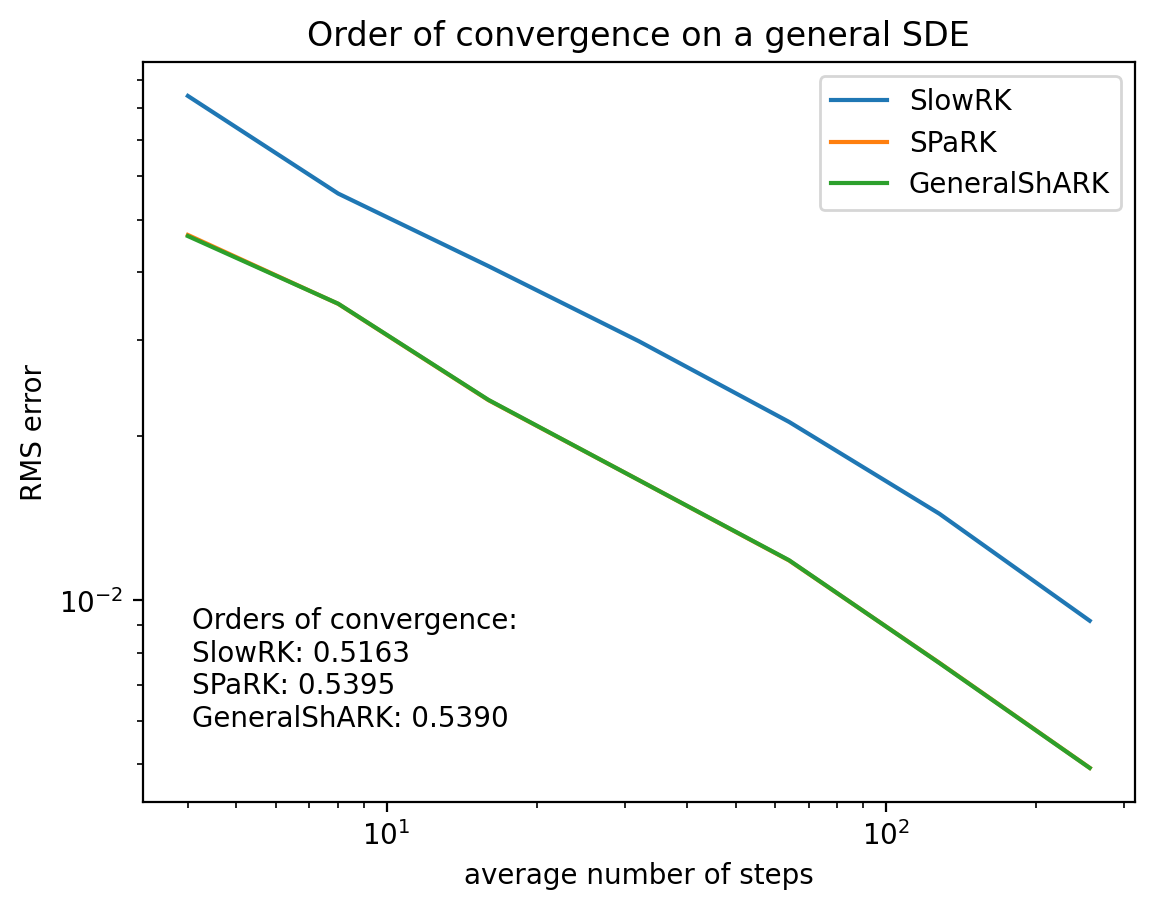

In [11]:
draw_order_multiple(
    [out_SLOWRK_mlp_sde, out_SPaRK_mlp_sde, out_GenShARK_mlp_sde],
    ["SlowRK", "SPaRK", "GeneralShARK"],
    title="Order of convergence on a general SDE",
)

## Commutative noise SDEs

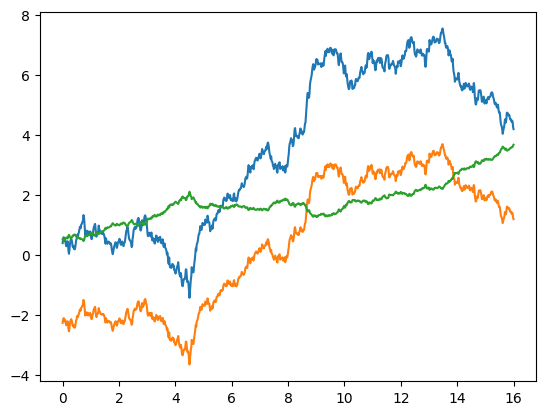

In [6]:
# A plot of the solution of the commutative-noise SDE used to compare the methods
# A plot of the solution of the SDE
# We will use this to compare the methods
sol_commutative = diffeqsolve(
    terms_commutative_sde,
    GeneralShARK(),
    t0,
    t1,
    dt0=0.02,
    y0=commutative_sde.y0,
    args=commutative_sde.args,
    saveat=diffrax.SaveAt(steps=True),
)
plot_sol_general(sol_commutative)

In [6]:
# A comparison of SlowRK, SPaRK and GeneralShARK for commutative noise SDEs
# We compute their orders and plot them on the same graph
out_SLOWRK_commutative_sde = constant_step_strong_order(
    keys, commutative_sde_short, SlowRK(), levels=(4, 10)
)
out_SPaRK_commutive_sde = constant_step_strong_order(
    keys, commutative_sde_short, SPaRK(), levels=(4, 10)
)
out_GenShARK_commutative_sde = constant_step_strong_order(
    keys, commutative_sde_short, GeneralShARK(), levels=(4, 10)
)

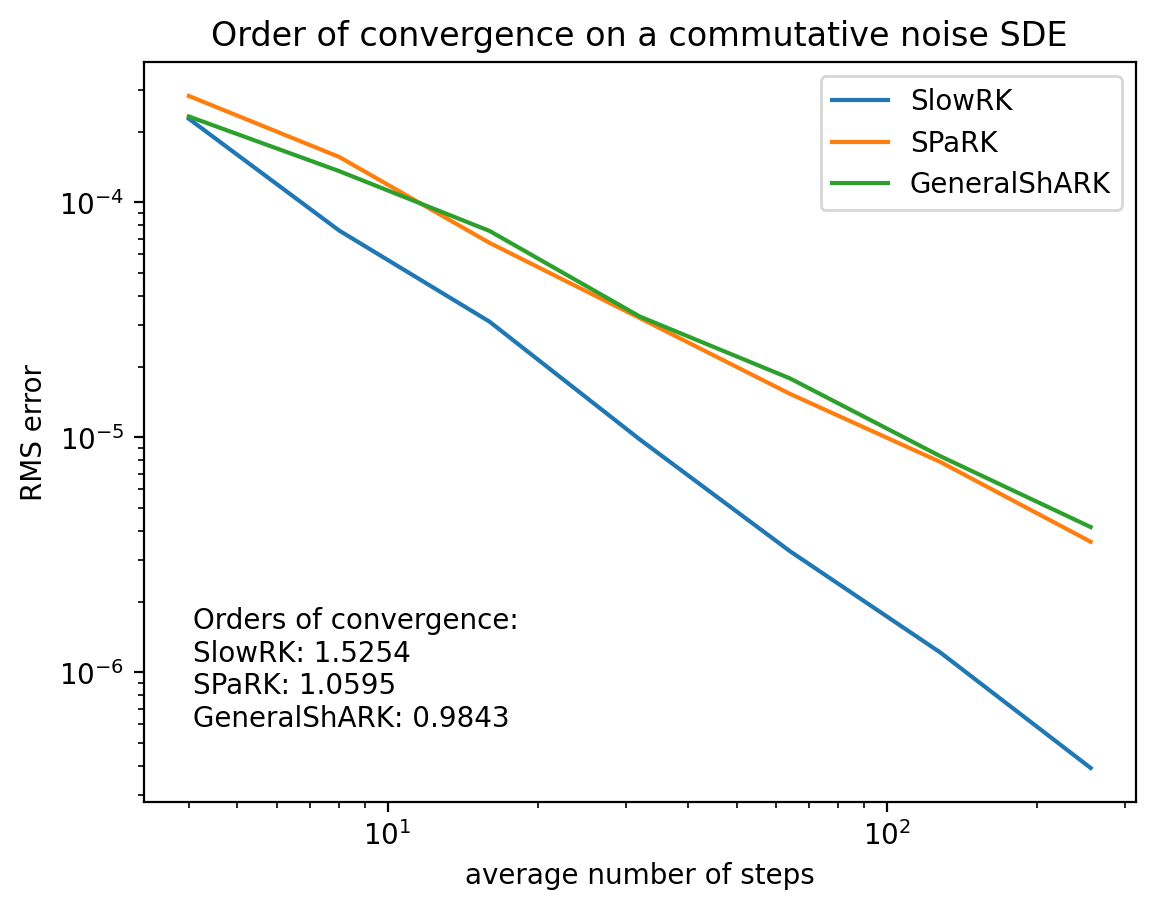

In [12]:
draw_order_multiple(
    [
        out_SLOWRK_commutative_sde,
        out_SPaRK_commutive_sde,
        out_GenShARK_commutative_sde,
    ],
    ["SlowRK", "SPaRK", "GeneralShARK"],
    title="Order of convergence on a commutative noise SDE",
)

## Additive noise SDEs

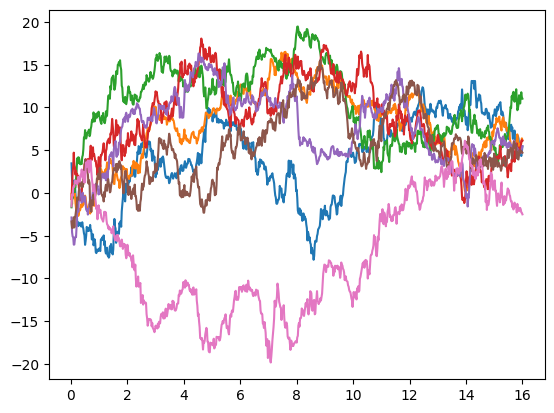

In [3]:
# A plot of the solution of the additive-noise SDE used to compare the methods
# A plot of the solution of the SDE
# We will use this to compare the methods
sol_additive = diffeqsolve(
    terms_time_sde,
    ShARK(),
    t0,
    t1,
    dt0=0.02,
    y0=time_sde.y0,
    args=time_sde.args,
    saveat=diffrax.SaveAt(steps=True),
)
plot_sol_general(sol_additive)

In [5]:
# A comparison of SRKs for additive noise SDEs
# We compute their orders and plot them on the same graph
out_SLOWRK_time_sde = constant_step_strong_order(
    keys, time_sde_short, SlowRK(), levels=(4, 10)
)
out_SPaRK_time_sde = constant_step_strong_order(
    keys, time_sde_short, SPaRK(), levels=(4, 10)
)
out_GenShARK_time_sde = constant_step_strong_order(
    keys, time_sde_short, GeneralShARK(), levels=(4, 10)
)
out_ShARK_time_sde = constant_step_strong_order(
    keys, time_sde_short, ShARK(), levels=(4, 10)
)
out_SRA1_time_sde = constant_step_strong_order(
    keys, time_sde_short, SRA1(), levels=(4, 10)
)

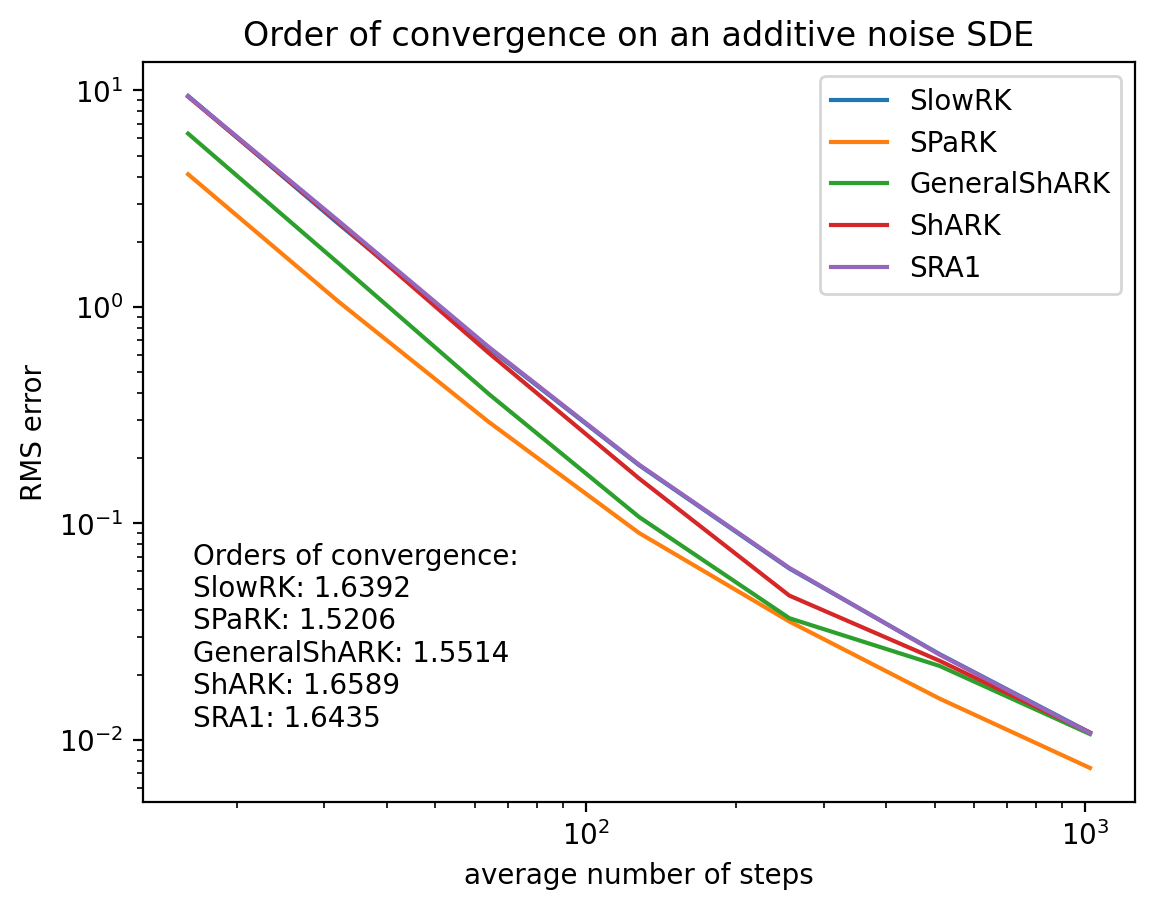

In [6]:
draw_order_multiple(
    [
        out_SLOWRK_time_sde,
        out_SPaRK_time_sde,
        out_GenShARK_time_sde,
        out_ShARK_time_sde,
        out_SRA1_time_sde,
    ],
    ["SlowRK", "SPaRK", "GeneralShARK", "ShARK", "SRA1"],
    title="Order of convergence on an additive noise SDE",
)